# Image Classification with Object Based Image Analysis (OBIA) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas
import skimage

from skimage import util
from skimage.segmentation import mark_boundaries, slic
from tqdm import tqdm

In [5]:
def stretch_histogram(band, min_out=0, max_out=255):
    min_in, max_in = np.percentile(band, (2, 98))  # Considerando 2% - 98% para evitar outliers
    stretched = (band - min_in) * ((max_out - min_out) / (max_in - min_in)) + min_out
    stretched = np.clip(stretched, min_out, max_out)
    return stretched / 255

In [6]:
#Set image path
image = './images/Crops_USA.tif'
#Open image
with rio.open(image) as f:
    img = f.read([1,2,3,4]).astype(float) 
    
    max_value = img.max()
    img /= max_value  # Image Normalize
    
    red, green, blue, nir = img
    

In [7]:
rgb = stretch_histogram(np.stack([red, green, blue], axis=-1))
ndvi = (nir - red) / (nir + red + 1e-10)
ndwi = (green - nir) / (green + nir + 1e-10)

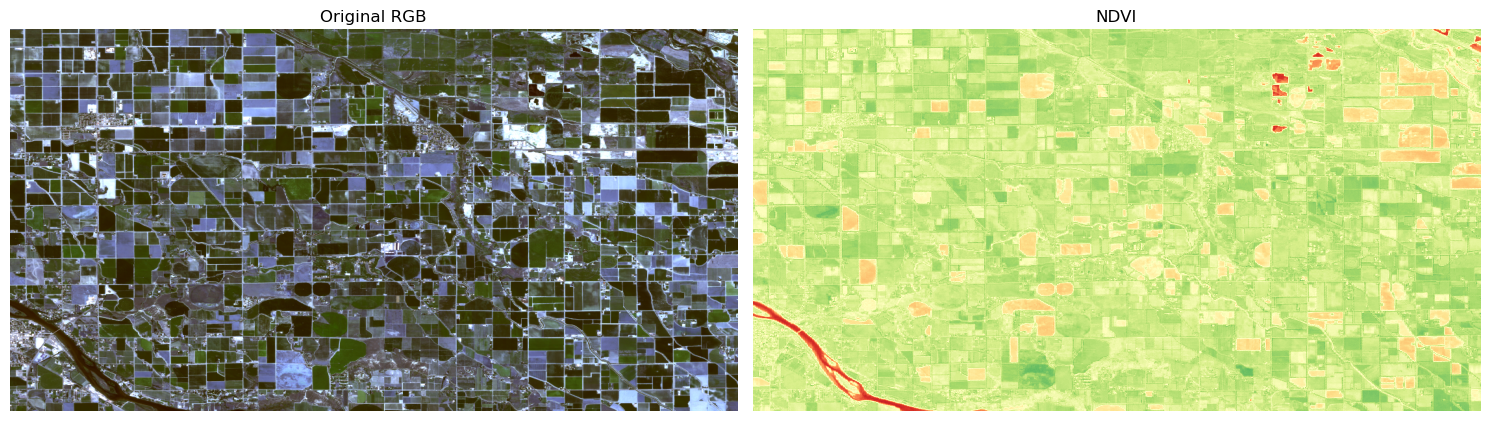

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (15,18))

#Plotting the RGB
ax[0].imshow(rgb)
ax[0].set_title('Original RGB')
ax[0].axis('off')

ax[1].imshow(ndvi, cmap="RdYlGn")
ax[1].set_title('NDVI')
ax[1].axis('off')

plt.tight_layout()
plt.show()

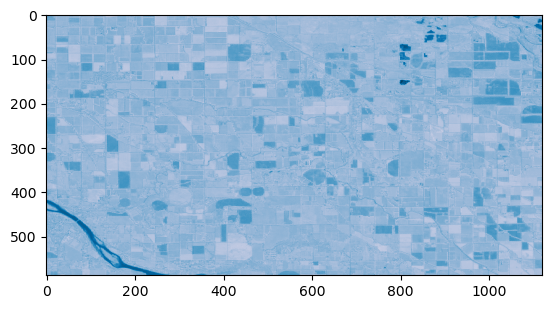

In [9]:
plt.imshow(ndwi, cmap="PuBu");

In [10]:
ndvi.min(), ndvi.max()

(-0.5437921073566061, 0.5408936924578073)

# Manual Thresholding

In [11]:
#NDVI Thresholds
thresholds = [-0.1, -0.05, 0, 0.05, 0.1]

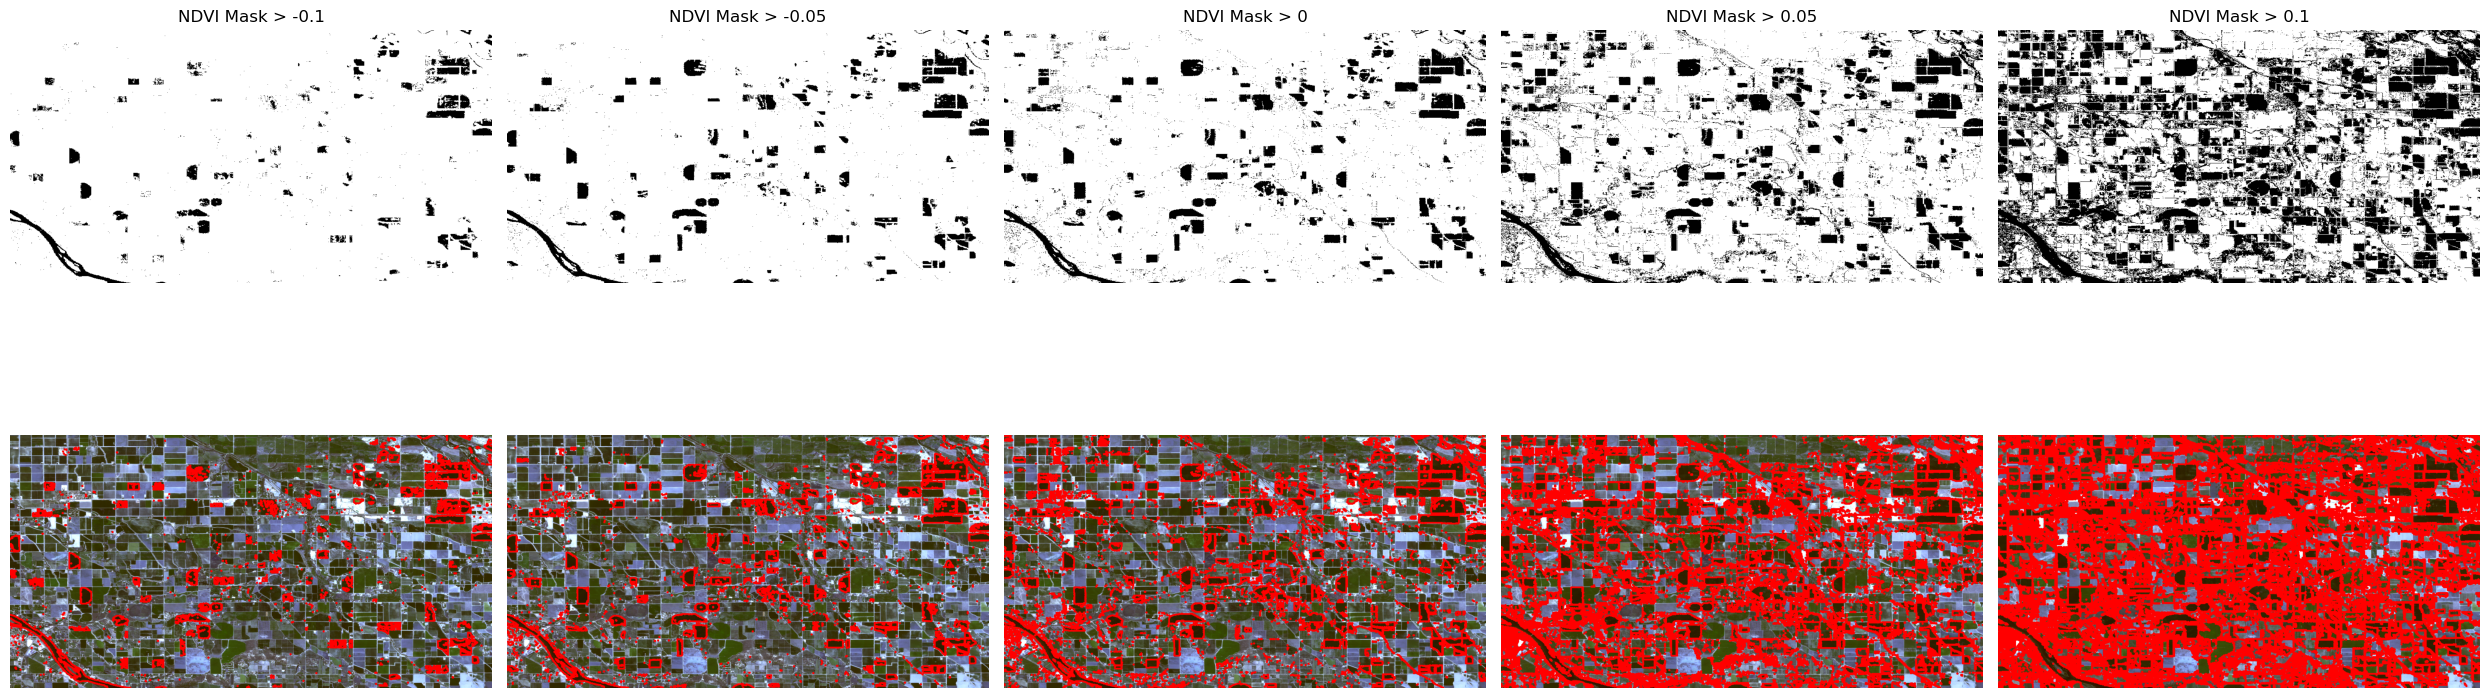

In [12]:
fig, axs = plt.subplots(
    ncols=len(thresholds),
    nrows = 2,
    figsize = (5 * len(thresholds), 10)
)

for i, threshold in enumerate(thresholds):
    mask = ndvi > threshold

    axs[0,i].imshow(mask, cmap = 'gray')
    axs[0,i].set_title(f"NDVI Mask > {threshold}")
    axs[0,i].axis('off')

    axs[1, i].imshow(mark_boundaries(rgb, mask, color = (1,0,0), outline_color=(1,0,0), mode ="thick"))
    axs[1,i].axis('off')

plt.tight_layout()
plt.show()

# Automated Threhsolding

### a) Otsu

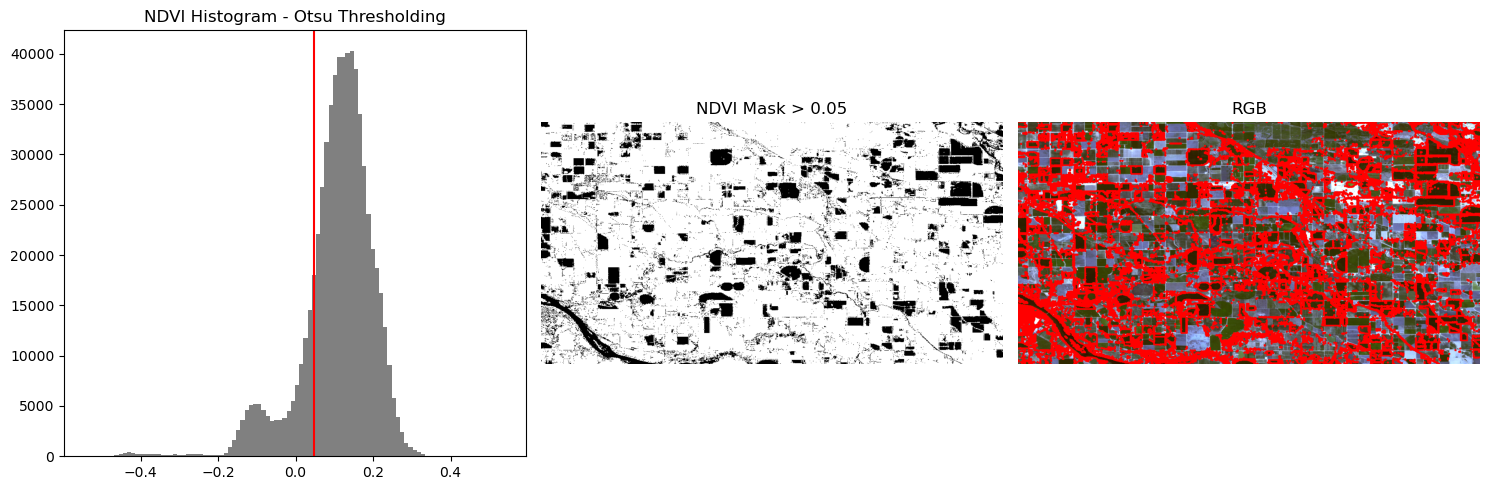

In [13]:
otsu_thrs = skimage.filters.threshold_otsu(ndvi)

fig, axs = plt.subplots(ncols = 3, figsize=(15,5))

axs[0].hist(ndvi.ravel(), bins = 100, color = 'grey')
axs[0].axvline(otsu_thrs, color = 'red')
axs[0].set_title("NDVI Histogram - Otsu Thresholding")

mask = ndvi > otsu_thrs
axs[1].imshow(mask > otsu_thrs, cmap = "grey")
axs[1].set_title(f"NDVI Mask > {otsu_thrs:.2f}")
axs[1].set_axis_off()

axs[2].imshow(mark_boundaries(rgb, mask, color = (1,0,0), outline_color=(1,0,0), mode ="thick"))
axs[2].set_title('RGB')
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

### b) Multi Otsu

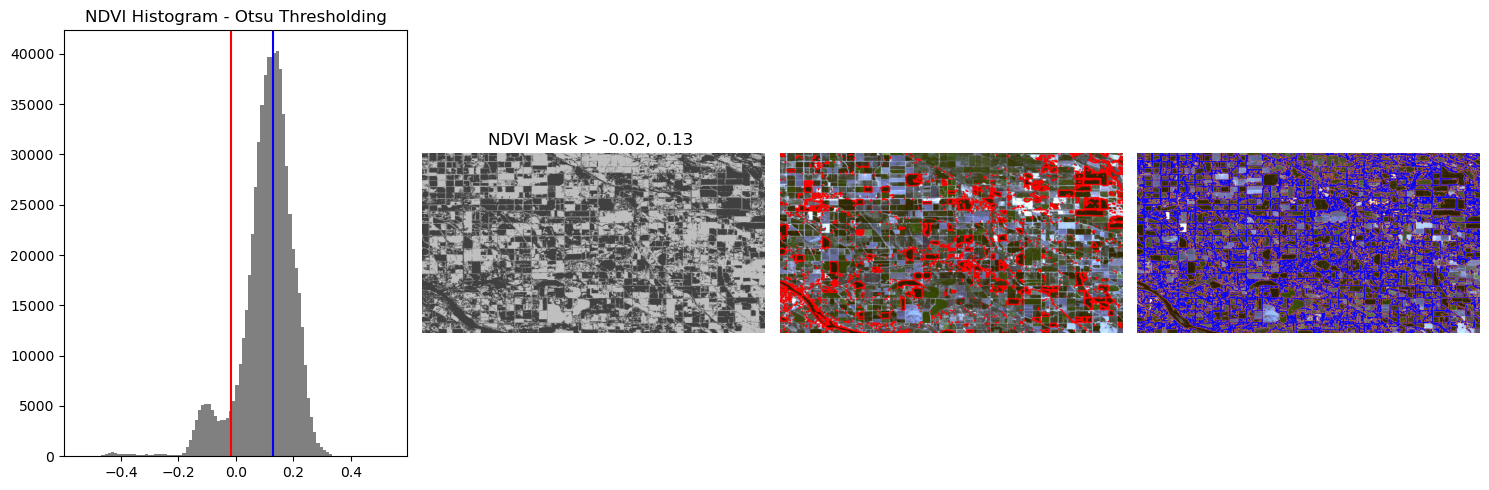

In [14]:
multiotsu_thrs = skimage.filters.threshold_multiotsu(ndvi, classes = 3)

color_ramp = ["red", "blue"]

fig, axs = plt.subplots(ncols = 4, figsize=(15,5))

axs[0].hist(ndvi.ravel(), bins = 100, color = 'grey')
for t, color in zip(multiotsu_thrs, color_ramp):
    axs[0].axvline(t, color = color)
axs[0].set_title("NDVI Histogram - Otsu Thresholding")

mask_1 = ndvi > multiotsu_thrs[0]
mask_2 = ndvi > multiotsu_thrs[1]

axs[1].imshow(mask_1 > multiotsu_thrs[0], alpha = 0.5, cmap = "grey")
axs[1].imshow(mask_2 > multiotsu_thrs[1], alpha = 0.5, cmap = "grey")

axs[1].set_title(f"NDVI Mask > {multiotsu_thrs[0]:.2f}, {multiotsu_thrs[1]:.2f} ")
axs[1].set_axis_off()

rgb_with_boundaries_1 = mark_boundaries(rgb, mask_1, color=(1, 0, 0), outline_color=(1, 0, 0), mode="thick")
rgb_with_boundaries_2 = mark_boundaries(rgb, mask_2, color=(0, 0, 1), outline_color=(1, 0.5, 0), mode="thick")
axs[2].imshow(rgb_with_boundaries_1)
axs[2].set_axis_off()

axs[3].imshow(rgb_with_boundaries_2)
axs[3].set_axis_off()

plt.tight_layout()
plt.show()

Based on the multiple otsu thresholding, we can see what could be considered water/unhealthy crops and healthy crops. 

# Segments Classification

In [16]:
import matplotlib.colors as mcolors
from matplotlib import rcParams

# Function to create a random colormap
def get_random_cmap(num_colors, base_cmap="Spectral"):
    # Get base colormap
    base_cmap = plt.get_cmap(base_cmap)
    # Randomly choose colors from the colormap
    random_colors = [base_cmap(i) for i in np.random.choice(range(base_cmap.N), num_colors)]
    # Create a colormap with those random colors
    return mcolors.ListedColormap(random_colors)

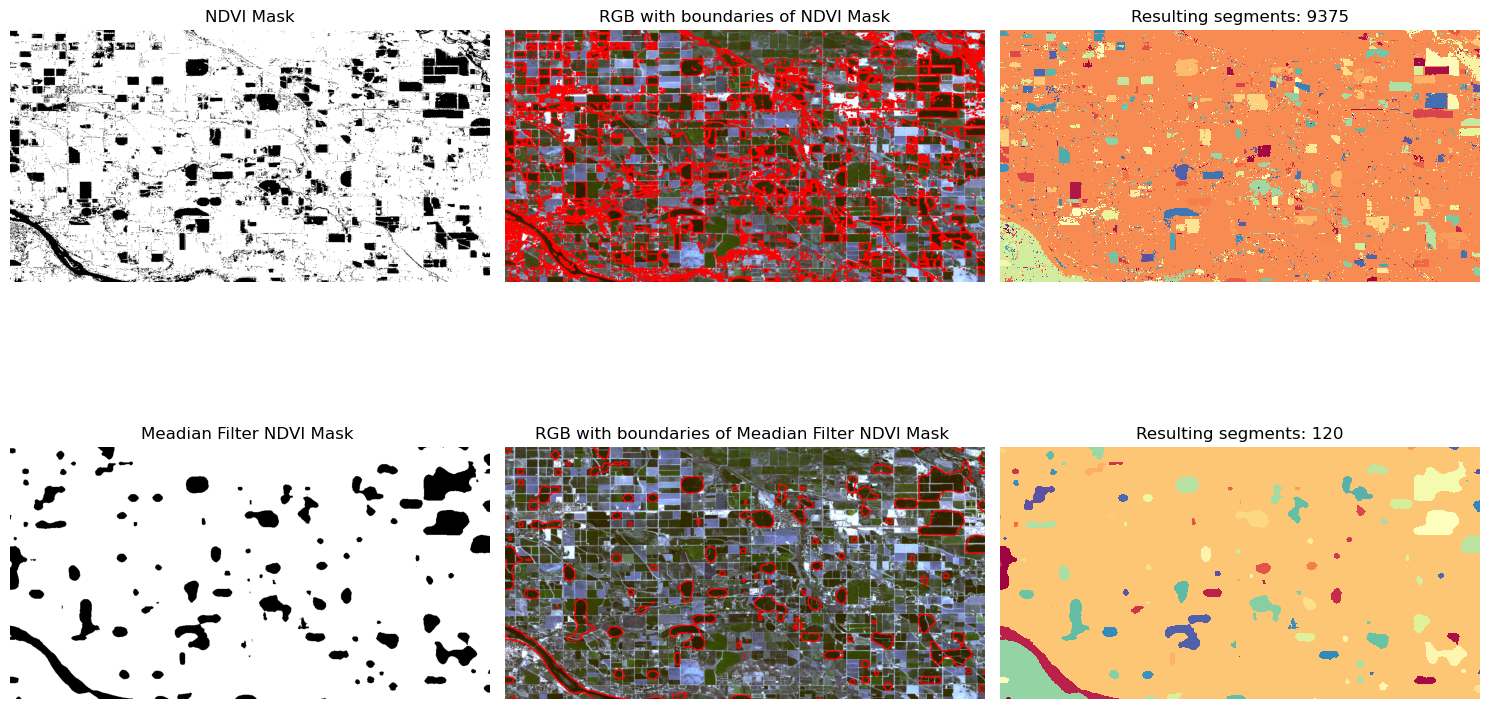

In [19]:
otsu = skimage.filters.threshold_otsu(ndvi)
mask = ndvi > otsu

# Create a structure element and apply a median filter
se = skimage.morphology.square(20)
filtered_mask = skimage.filters.median(mask, se)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

masks = [mask, filtered_mask]
title = ["NDVI Mask", "Meadian Filter NDVI Mask "]

for i in range(2):
    #Plot masks
    axs[i,0].imshow(masks[i], cmap = 'grey')
    axs[i,0].set_title(title[i])
    axs[i,0].set_axis_off()

    # Plot RGB with boundaries from masks
    rgb_boundaries = mark_boundaries(rgb, masks[i], color = (1,0,0), outline_color = (1,0,0))
    axs[i,1].imshow(rgb_boundaries)
    axs[i,1].set_title(f"RGB with boundaries of {title[i]}")
    axs[i,1].set_axis_off()

    # Plot and label segments from masks
    labeled_segments = skimage.measure.label(masks[i].astype("int"), background = -1)
    n_segments = len(np.unique(labeled_segments))
    axs[i,2].imshow(labeled_segments, cmap = get_random_cmap(n_segments), interpolation = "nearest")
    axs[i,2].set_title(f"Resulting segments: {n_segments}")
    axs[i,2].set_axis_off()

plt.tight_layout()
plt.show()

# Resources 

- [OBIA Tutorials](https://github.com/mariarodriguezn/obia_tutorials/blob/main/01_segmentation.ipynb)